<a href="https://colab.research.google.com/github/hamojb/AD_research/blob/main/colab_playaround.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from nibabel.testing import data_path
import tensorflow as tf
import nibabel as nib
import os, psutil
from collections import Counter
process = psutil.Process(os.getpid())
print(process.memory_info().rss)

371462144


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7608472834398121139, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1230456695961323482
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Define Helper Functions

In [5]:
def show_slices(slices, col = None):
  """ Function to display row of image slices """
  fig, axes = plt.subplots(1, len(slices))
  for i, slice in enumerate(slices):
      axes[i].imshow(slice.T, cmap=col, origin="lower")
  return

def read_data(data_path: str): 
  """ Function to read in data of each brain scan """
  temp_path = os.path.join(data_path)
  temp_img = nib.load(temp_path)
  # return temp_img
  temp_data = temp_img.get_fdata()
  return temp_data



def produce_image(data_path: str): 
  """ Function to read in data of each brain scan """
  temp_path = os.path.join(data_path)
  temp_img = nib.load(temp_path)
  return temp_img

# def populate_images(oasis_dir):#, df):
#   """ Function to populate data """ 
#   data = []
#   images = []
#   filenames = []
#   for filename in os.listdir(oasis_dir):
#     print(filename)
#     # if file_str in df
#       # new_data, img = read_data(oasis_dir + filename)
#       # data.append(new_data)
#       # images.append(img)
#   return data, images, filenames

def populate_images(oasis_dir, train_val_test):
  """ Function to populate data """ 
  ret_df = {}
  for filename in os.listdir(oasis_dir):
    new_str = filename.split(".")[0].split("_")[0]
    scan = filename.split(".")[0]
    if new_str in train_val_test:
      new_data = read_data(oasis_dir + filename)
      ret_df[scan] = new_data
    else: 
      continue
    
  return ret_df

def match_data(scan_data, diagnosis_data): 
  empty_df = pd.DataFrame()
  scan_patients = list(set(scan_data.Subject.values))
  for patient in scan_patients:
    temp_scans = scan_data[scan_data['Subject'] == patient]
    temp_scans = temp_scans.sort_values('ID')
    temp_diag = diagnosis_data[diagnosis_data['Subject'] == patient]
    temp_diag = temp_diag.sort_values('ID')
    test = pd.merge_asof(temp_scans, temp_diag, on="ID", allow_exact_matches=True, direction = "forward")
    empty_df = empty_df.append(test)
  empty_df = empty_df.drop(columns = ['Inserted_x', 'Inserted_y', 'Subject_y', 'ageAtEntry'])
  empty_df = empty_df.rename(columns = {"Subject_x":"Subject","FS_FSDATA ID":"MRI_ID"})
  empty_df = empty_df.reset_index().drop(columns = ["index"])
  empty_df = empty_df.dropna()
  return empty_df

Quick demonstation on how to read the data in using the `nibabel` package

In [6]:
path = os.path.join("/content/drive/MyDrive/oasis_original/OAS30001_Freesurfer53_d0129.mgz.nii.gz")
img = nib.load(path)
data = img.get_fdata()

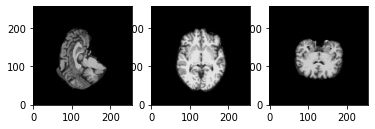

In [7]:
slice_0 = data[128, :, :]
slice_1 = data[:, 128, :]
slice_2 = data[:, :, 128]
show_slices([slice_0, slice_1, slice_2], "gray")

Define functions to read all data in from `oasis_originals`. 

# Read data and store in variable. 

In [8]:
clinical_data = pd.read_csv("/content/drive/MyDrive/extra_data/clinical_data.csv")
clinical_data['ID'] = clinical_data['ADRC_ADRCCLINICALDATA ID'].str.split('_ClinicalData_', 1, expand=True)[1]
clinical_data = clinical_data.drop(columns = ['ADRC_ADRCCLINICALDATA ID', 'Date', 'Subject.1', 'id'])
clinical_data['Inserted'] = pd.to_datetime(clinical_data['Inserted'])
clinical_data['ID'] = clinical_data['ID'].str.extract('(\d+)', expand=False).astype(int)

In [9]:
clinical_data

,Subject,ageAtEntry,cdr,Inserted,ID
0,OAS30001,65.149895,0.0,2017-12-20 10:54:32.956,0
1,OAS30001,65.149895,0.0,2017-12-20 10:54:33.466,339
2,OAS30001,65.149895,0.0,2017-12-20 10:54:33.673,722
3,OAS30001,65.149895,0.0,2017-12-20 10:54:33.891,1106
4,OAS30001,65.149895,0.0,2017-12-20 10:54:34.117,1456
...,...,...,...,...,...
6219,OAS31172,70.902120,0.0,2017-12-20 14:50:44.860,1215
6220,OAS31172,70.902120,0.0,2017-12-20 14:50:45.131,1565
6221,OAS31172,70.902120,0.0,2017-12-20 14:50:45.404,1908
6222,OAS31172,70.902120,0.0,2017-12-20 14:50:45.679,2816


In [10]:
scan_info = pd.read_csv("/content/drive/MyDrive/extra_data/freesurfers_mri_info.csv")
scan_info['ID'] = scan_info['FS_FSDATA ID'].str.split('_Freesurfer', 1, expand = True)[1]
scan_info = scan_info.drop(columns = ['Session', 'FS Date'])
scan_info.ID = scan_info.ID.str[3:]
scan_info['Inserted'] = pd.to_datetime(scan_info['Inserted'])
scan_info['ID'] = scan_info['ID'].str.extract('(\d+)', expand=False).astype(int)

In [11]:
scan_info

,FS_FSDATA ID,Subject,Inserted,ID
0,OAS30001_Freesurfer53_d0129,OAS30001,2017-11-15 13:26:34.150,129
1,OAS30001_Freesurfer53_d0757,OAS30001,2017-12-13 13:44:44.891,757
2,OAS30001_Freesurfer53_d2430,OAS30001,2017-11-15 11:10:13.939,2430
3,OAS30001_Freesurfer53_d3132,OAS30001,2017-10-20 12:44:27.928,3132
4,OAS30002_Freesurfer53_d0653,OAS30002,2017-11-10 12:45:42.205,653
...,...,...,...,...
2042,OAS31168_Freesurfer53_d2526,OAS31168,2017-11-09 14:22:52.248,2526
2043,OAS31169_Freesurfer53_d0620,OAS31169,2017-10-18 15:15:06.880,620
2044,OAS31170_Freesurfer53_d2410,OAS31170,2017-10-18 15:15:06.574,2410
2045,OAS31172_Freesurfer53_d0407,OAS31172,2017-10-18 15:15:06.817,407


In [12]:
scan_and_diag = match_data(scan_info, clinical_data)
scans_sorted = scan_and_diag.sort_values(["Subject", "ID"]).reset_index().drop(columns = ["index", "ID"])
scans_sorted

,MRI_ID,Subject,cdr
0,OAS30001_Freesurfer53_d0129,OAS30001,0.0
1,OAS30001_Freesurfer53_d0757,OAS30001,0.0
2,OAS30001_Freesurfer53_d2430,OAS30001,0.0
3,OAS30001_Freesurfer53_d3132,OAS30001,0.0
4,OAS30002_Freesurfer53_d0653,OAS30002,0.0
...,...,...,...
1824,OAS31168_Freesurfer53_d2526,OAS31168,0.0
1825,OAS31169_Freesurfer53_d0620,OAS31169,0.5
1826,OAS31170_Freesurfer53_d2410,OAS31170,1.0
1827,OAS31172_Freesurfer53_d0407,OAS31172,0.0


In [13]:
ALTERNATIVE_CASE = True
if ALTERNATIVE_CASE: 
  scans_sorted['cdr'] = scans_sorted['cdr'].astype(str).replace({'0.0':'HC', '0.5': 'MCI', '1.0': 'MCI', '2.0': 'AD', '3.0': 'AD'})
scans_sorted

,MRI_ID,Subject,cdr
0,OAS30001_Freesurfer53_d0129,OAS30001,HC
1,OAS30001_Freesurfer53_d0757,OAS30001,HC
2,OAS30001_Freesurfer53_d2430,OAS30001,HC
3,OAS30001_Freesurfer53_d3132,OAS30001,HC
4,OAS30002_Freesurfer53_d0653,OAS30002,HC
...,...,...,...
1824,OAS31168_Freesurfer53_d2526,OAS31168,HC
1825,OAS31169_Freesurfer53_d0620,OAS31169,MCI
1826,OAS31170_Freesurfer53_d2410,OAS31170,MCI
1827,OAS31172_Freesurfer53_d0407,OAS31172,HC


In [14]:
Counter(scans_sorted['cdr'])

Counter({'AD': 20, 'HC': 1460, 'MCI': 349})

We will now check to make sure that in our directory of images we have the correct MRI_IDs to link to the existing data. 

In [15]:
num = 0
for i in os.listdir(r'/content/drive/MyDrive/oasis_original/'):
  if i.split(".")[0] in scans_sorted.MRI_ID.values: 
    num += 1
print(num)

1824


In [16]:
subj_ids = list(set(scans_sorted["Subject"]))
inv_test = int(0.15*len(subj_ids))
print(inv_test)

140


In [17]:
from random import shuffle
shuffle(subj_ids)
train_val = subj_ids[inv_test:]
train = train_val[inv_test:]
val = train_val[:inv_test]
test = subj_ids[:inv_test]

In [18]:
# len(train)/8

In [19]:
len(val)

140

In [20]:
len(test)

140

In [21]:
overlaps = set(train).intersection(val, test)
if len(overlaps) == 0: 
  print("CLEAR: No overlaps")
else: 
  print("ERROR: Overlaps exist")
  print(overlaps)

CLEAR: No overlaps


In [22]:
training = scans_sorted[scans_sorted['Subject'].isin(train)]
training.head()

,MRI_ID,Subject,cdr
0,OAS30001_Freesurfer53_d0129,OAS30001,HC
1,OAS30001_Freesurfer53_d0757,OAS30001,HC
2,OAS30001_Freesurfer53_d2430,OAS30001,HC
3,OAS30001_Freesurfer53_d3132,OAS30001,HC
13,OAS30004_Freesurfer53_d1101,OAS30004,HC


In [23]:
training[training.cdr == 'AD']

,MRI_ID,Subject,cdr
63,OAS30031_Freesurfer53_d0427,OAS30031,AD
198,OAS30114_Freesurfer53_d0086,OAS30114,AD
274,OAS30158_Freesurfer53_d2467,OAS30158,AD
396,OAS30244_Freesurfer53_d1526,OAS30244,AD
609,OAS30373_Freesurfer53_d1211,OAS30373,AD
660,OAS30408_Freesurfer50_d1193,OAS30408,AD
1162,OAS30753_Freesurfer53_d0035,OAS30753,AD
1261,OAS30811_Freesurfer53_d7690,OAS30811,AD
1336,OAS30860_Freesurfer50_d0638,OAS30860,AD
1472,OAS30948_Freesurfer53_d0076,OAS30948,AD


In [24]:
validation = scans_sorted[scans_sorted['Subject'].isin(val)]
validation.head()

,MRI_ID,Subject,cdr
26,OAS30007_Freesurfer53_d0061,OAS30007,HC
27,OAS30007_Freesurfer53_d1641,OAS30007,HC
28,OAS30007_Freesurfer53_d1981,OAS30007,HC
33,OAS30009_Freesurfer53_d0148,OAS30009,HC
34,OAS30009_Freesurfer53_d1210,OAS30009,HC


In [25]:
validation[validation.cdr == 'AD']

,MRI_ID,Subject,cdr
166,OAS30098_Freesurfer53_d0036,OAS30098,AD
950,OAS30616_Freesurfer53_d0199,OAS30616,AD
1543,OAS30994_Freesurfer53_d0070,OAS30994,AD
1613,OAS31033_Freesurfer53_d0002,OAS31033,AD


In [26]:
testing = scans_sorted[scans_sorted['Subject'].isin(test)]
testing.head()

,MRI_ID,Subject,cdr
4,OAS30002_Freesurfer53_d0653,OAS30002,HC
5,OAS30002_Freesurfer53_d2340,OAS30002,HC
6,OAS30002_Freesurfer53_d2345,OAS30002,HC
7,OAS30003_Freesurfer53_d0558,OAS30003,HC
8,OAS30003_Freesurfer53_d1631,OAS30003,HC


In [27]:
testing[testing.cdr == 'AD']

,MRI_ID,Subject,cdr
257,OAS30145_Freesurfer53_d4247,OAS30145,AD
1322,OAS30853_Freesurfer53_d0100,OAS30853,AD
1342,OAS30865_Freesurfer53_d0109,OAS30865,AD


In [28]:
Counter(training['cdr'])

Counter({'AD': 13, 'HC': 1016, 'MCI': 246})

In [29]:
Counter(validation['cdr'])

Counter({'AD': 4, 'HC': 216, 'MCI': 55})

In [30]:
Counter(testing['cdr'])

Counter({'AD': 3, 'HC': 228, 'MCI': 48})

Good enough... for now 

In [31]:
# val1 = val[:int(len(val)/2)]
# val2 = val[int(len(val)/2):]

In [32]:
train1 = train[:10]

In [33]:
directory = r'/content/drive/MyDrive/oasis_original/'
train_data1 = populate_images(directory, train1)
# val_data = populate_images(directory, val)

# test_data = populate_images(directory, test)
# train_data = populate_images(directory, train)


In [34]:
train_data1

{'OAS30092_Freesurfer50_d0636': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         

In [170]:
df = pd.DataFrame(list(train_data1.items()),columns = ['MRI_ID','Data'])

In [171]:
new_one = training.merge(df, how = "left", on = "MRI_ID")

In [172]:
new_one

,MRI_ID,Subject,cdr,Data
0,OAS30001_Freesurfer53_d0129,OAS30001,HC,NaN
1,OAS30001_Freesurfer53_d0757,OAS30001,HC,NaN
2,OAS30001_Freesurfer53_d2430,OAS30001,HC,NaN
3,OAS30001_Freesurfer53_d3132,OAS30001,HC,NaN
4,OAS30003_Freesurfer53_d0558,OAS30003,HC,NaN
...,...,...,...,...
1285,OAS31167_Freesurfer53_d4564,OAS31167,HC,NaN
1286,OAS31168_Freesurfer53_d0148,OAS31168,HC,NaN
1287,OAS31168_Freesurfer53_d1566,OAS31168,HC,NaN
1288,OAS31168_Freesurfer53_d2526,OAS31168,HC,NaN


In [173]:
playaround_data = new_one[new_one['Data'].notnull()]

In [174]:
len(playaround_data)

18

In [175]:
y = playaround_data['cdr'].values
x = playaround_data['Data'].to_list()
import psutil
from tensorflow.keras.utils import to_categorical
y = pd.get_dummies(y)
y = to_categorical(y, num_classes = 3)
import tensorflow as tf


In [176]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-gpu

In [177]:
!pip install monai

In [178]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader, ImageDataset
from monai.utils import set_determinism

print_config()

MONAI version: 0.6.0
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [179]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt
import h5py

In [180]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

In [181]:
train1 = training[40:45]
train1['MRI_ID'] = '/content/drive/MyDrive/oasis_original/' + train1['MRI_ID'] + ".mgz.nii.gz"
train1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MRI_ID,Subject,cdr
54,/content/drive/MyDrive/oasis_original/OAS30026...,OAS30026,HC
61,/content/drive/MyDrive/oasis_original/OAS30029...,OAS30029,MCI
62,/content/drive/MyDrive/oasis_original/OAS30030...,OAS30030,HC
64,/content/drive/MyDrive/oasis_original/OAS30032...,OAS30032,HC
65,/content/drive/MyDrive/oasis_original/OAS30032...,OAS30032,HC


In [182]:
trainX = train1['MRI_ID'].values
trainX

array(['/content/drive/MyDrive/oasis_original/OAS30026_Freesurfer53_d0696.mgz.nii.gz',
       '/content/drive/MyDrive/oasis_original/OAS30029_Freesurfer53_d0131.mgz.nii.gz',
       '/content/drive/MyDrive/oasis_original/OAS30030_Freesurfer53_d0170.mgz.nii.gz',
       '/content/drive/MyDrive/oasis_original/OAS30032_Freesurfer50_d0262.mgz.nii.gz',
       '/content/drive/MyDrive/oasis_original/OAS30032_Freesurfer53_d1661.mgz.nii.gz'],
      dtype=object)

In [183]:
trainY = pd.get_dummies(train1['cdr'])
trainY

,HC,MCI
54,1,0
61,0,1
62,1,0
64,1,0
65,1,0


In [184]:

trainX = train1['MRI_ID'].values
trainX = list(trainX)

In [185]:
trainX

['/content/drive/MyDrive/oasis_original/OAS30026_Freesurfer53_d0696.mgz.nii.gz',
 '/content/drive/MyDrive/oasis_original/OAS30029_Freesurfer53_d0131.mgz.nii.gz',
 '/content/drive/MyDrive/oasis_original/OAS30030_Freesurfer53_d0170.mgz.nii.gz',
 '/content/drive/MyDrive/oasis_original/OAS30032_Freesurfer50_d0262.mgz.nii.gz',
 '/content/drive/MyDrive/oasis_original/OAS30032_Freesurfer53_d1661.mgz.nii.gz']

In [186]:
trainY

,HC,MCI
54,1,0
61,0,1
62,1,0
64,1,0
65,1,0


In [187]:
train_transforms = Compose([LoadImage(image_only=True)])

In [188]:
trainY.iloc[4,]

HC     1
MCI    0
Name: 65, dtype: uint8

In [189]:
num_class = 3

In [190]:
train_ds = ImageDataset(image_files=trainX, labels=trainY, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=2)

In [191]:
act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

In [192]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
for epoch in range(5):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{5}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        print(batch_data[0])
        print(batch_data[1])
        print(batch_data)
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", metric, epoch + 1)
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/5


In [ ]:
train_ds

In [ ]:
train_loader

In [ ]:
import torch

In [ ]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=3
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 4
val_interval = 1

In [ ]:
!pip install -q "monai[nibabel]"

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // playaround_data.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

In [ ]:
for i in train_loader: 
  print(i)

In [ ]:
x

In [ ]:
# x = np.asarray(x).astype('float32')